### Recommendations for: https://www.kaggle.com/CooperUnion/anime-recommendations-database
### My public kernel: https://www.kaggle.com/podsyp/anime-recommendations-with-surprise

# Context
This data set contains information on user preference data from 73,516 users on 12,294 anime. Each user is able to add anime to their completed list and give it a rating and this data set is a compilation of those ratings.

## Content

Anime.csv
* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".

Rating.csv
* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

## Acknowledgements
Thanks to myanimelist.net API for providing anime data and user ratings.

## Inspiration
Building a better anime recommendation system based only on user viewing history.

# Import

In [1]:
import numpy as np
import pandas as pd

In [2]:
import pandas_summary as ps

from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import SVD, SlopeOne, NMF
from surprise.accuracy import rmse
from surprise import accuracy
from surprise.model_selection import train_test_split

In [3]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [4]:
folder = 'data/'
anime_df = pd.read_csv(folder+'anime.csv')
rate_df = pd.read_csv(folder+'rating.csv')

In [5]:
print('anime: ', anime_df.shape)
print('rating: ', rate_df.shape)

anime:  (12294, 7)
rating:  (7813737, 3)


In [6]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [7]:
rate_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [8]:
full_df = rate_df.merge(anime_df, how='left', left_on=['anime_id'], right_on=['anime_id'])
df = full_df[full_df['rating_x'] != -1]
df.head()

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
47,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892.0
81,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660.0
83,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100.0
101,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657.0
153,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315.0


In [9]:
full_df.shape, df.shape

((7813737, 9), (6337241, 9))

# EDA

In [10]:
dfs = ps.DataFrameSummary(full_df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['name', 'genre', 'type', 'episodes']
numerics:  ['user_id', 'anime_id', 'rating_x', 'rating_y', 'members']


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
count,7.81374e+06,7.81374e+06,7.81374e+06,NaN,NaN,NaN,NaN,7.81372e+06,7.81373e+06
mean,36728,8909.07,6.14403,NaN,NaN,NaN,NaN,7.65313,178621
std,20997.9,8883.95,3.7278,NaN,NaN,NaN,NaN,0.673029,188176
min,1,1,-1,NaN,NaN,NaN,NaN,1.67,29
25%,18974,1240,6,NaN,NaN,NaN,NaN,7.27,44030
50%,36791,6213,7,NaN,NaN,NaN,NaN,7.68,110470
75%,54757,14093,9,NaN,NaN,NaN,NaN,8.13,244268
max,73516,34519,10,NaN,NaN,NaN,NaN,9.5,1.01392e+06
counts,7813737,7813737,7813737,7813727,7813617,7813723,7813727,7813721,7813727
uniques,73515,11200,11,11196,3154,6,184,585,6487


In [11]:
dfs = ps.DataFrameSummary(df)
print('categoricals: ', dfs.categoricals.tolist())
print('numerics: ', dfs.numerics.tolist())
dfs.summary()

categoricals:  ['name', 'genre', 'type', 'episodes']
numerics:  ['user_id', 'anime_id', 'rating_x', 'rating_y', 'members']


,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
count,6.33724e+06,6.33724e+06,6.33724e+06,NaN,NaN,NaN,NaN,6.33723e+06,6.33724e+06
mean,36747.9,8902.87,7.8085,NaN,NaN,NaN,NaN,7.67498,184574
std,21013.4,8882,1.5725,NaN,NaN,NaN,NaN,0.669964,190953
min,1,1,1,NaN,NaN,NaN,NaN,2,33
25%,18984,1239,7,NaN,NaN,NaN,NaN,7.29,46803
50%,36815,6213,8,NaN,NaN,NaN,NaN,7.7,117091
75%,54873,14075,9,NaN,NaN,NaN,NaN,8.15,256325
max,73516,34475,10,NaN,NaN,NaN,NaN,9.37,1.01392e+06
counts,6337241,6337241,6337241,6337239,6337151,6337235,6337239,6337234,6337239
uniques,69600,9927,10,9926,3048,6,178,574,6474


In [12]:
data = df['rating_x'].value_counts().sort_index(ascending=False)
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
layout = dict(title = 'Distribution Of {} anime-ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [13]:
data = df.groupby('user_id')['rating_x'].count().clip(upper=250)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 250,
                                  size = 2))
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User (Clipped at 250)',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [14]:
data = df.groupby('anime_id')['rating_x'].count().clip(upper=250)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 250,
                                  size = 2))
layout = go.Layout(title = 'Distribution Of Number of Ratings Per anime_id (Clipped at 250)',
                   xaxis = dict(title = 'Ratings Per anime_id'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [15]:
data = df.groupby('genre')['rating_x'].count().clip(upper=250)

trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,
                                  end = 250,
                                  size = 2))
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Anime (Clipped at 250)',
                   xaxis = dict(title = 'Number of Ratings Per Anime'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

# Clip it

In [16]:
min_anime_ratings = 250
filter_anime = df['anime_id'].value_counts() > min_anime_ratings
filter_anime = filter_anime[filter_anime].index.tolist()

min_user_ratings = 250
filter_users = df['user_id'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['anime_id'].isin(filter_anime)) & (df['user_id'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(6337241, 9)
The new data frame shape:	(2368822, 9)


In [17]:
reader = Reader(rating_scale=(0, 10))
data = Dataset.load_from_df(df_new[['user_id', 'anime_id', 'rating_x']], reader)

# Cross Validation & Algorithm selection

In [18]:
benchmark = []
for algorithm in [SVD(biased=False), SlopeOne(), NMF()]:
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)

In [19]:
%time
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')

Wall time: 0 ns


In [20]:
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVD,1.088179,184.617960,7.343620
SlopeOne,1.155477,74.265848,287.120022
NMF,2.111284,208.083102,9.325933


### SVD algorithm showed the best test rmse

For any user, you can predict ratings that he has not yet set. You need to train the model so that it gives the smallest errors for already known models.

Prediction is the scalar product of a vector for a user and a vector for an object.

With this approach, much less model parameters need to be trained.

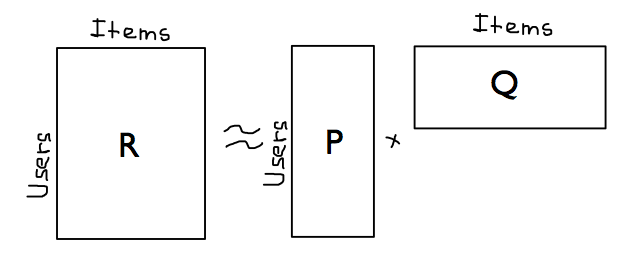

SVD cannot be directly applied, since there are a lot of missing values (more precisely, you can somehow fill them out, but the quality is not very good).
Therefore, the optimization problem is formulated according to well-known estimates $K$:

$$ min_{p, q} \sum_{u,i \in K} (r_{ui} - q_i^T p_u)^2 + \lambda (||q_i||^2 + ||p_u||^2)$$

In [21]:
%time
algo = SVD(biased=False)
cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=False)

Wall time: 0 ns


{'test_rmse': array([1.08876324, 1.0853384 , 1.08881599, 1.0876517 , 1.08712816]),
 'fit_time': (205.2567400932312,
  206.60481715202332,
  132.82759737968445,
  108.02117848396301,
  108.03717947006226),
 'test_time': (8.738499402999878,
  9.24552869796753,
  4.92328143119812,
  4.303246259689331,
  5.344305753707886)}

# Fit

In [22]:
%time
trainset, testset = train_test_split(data, test_size=0.25)
algo = SVD()
predictions = algo.fit(trainset).test(testset)
accuracy.rmse(predictions)

Wall time: 0 ns
RMSE: 1.0821


1.0821451111865723

In [23]:
def get_Iu(uid):
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError: 
        return 0
    
def get_Ui(iid):
    try: 
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0
    
df_ = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df_['Iu'] = df_.uid.apply(get_Iu)
df_['Ui'] = df_.iid.apply(get_Ui)
df_['err'] = abs(df_.est - df_.rui)

In [24]:
df_.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,46154,3588,8.0,8.551639,{'was_impossible': False},546,2582,0.551639
1,42635,2031,6.0,6.112495,{'was_impossible': False},1650,335,0.112495
2,41818,572,9.0,8.012579,{'was_impossible': False},355,1219,0.987421
3,40520,4081,7.0,7.691660,{'was_impossible': False},497,1481,0.691660
4,11397,92,6.0,7.412785,{'was_impossible': False},493,200,1.412785


# Predict

In [25]:
%time
data_pred = []
for row in full_df[full_df['rating_x'] == -1].itertuples():
    tmp_pred = algo.predict(row[1], row[2])
    data_pred.append((tmp_pred[0], tmp_pred[1], round(tmp_pred[3], 2)))
data_pred = pd.DataFrame(data_pred, columns=['user_id', 'anime_id', 'rating'])

Wall time: 0 ns


In [26]:
data_pred.head()

,user_id,anime_id,rating
0,1,20,7.51
1,1,24,8.13
2,1,79,7.45
3,1,226,7.80
4,1,241,6.63


In [27]:
data_pred.to_csv('submission.csv', index=False)